# Trabajo Nº1 – Clasificación de Perros y Gatos con CNN y Transfer Learning

In [24]:
# Añade aquí los import que utilices en tu código
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from PIL import Image
import pandas as pd

from sklearn.model_selection import train_test_split # para hacer la división de los datos
import matplotlib.image as mpimg # para ver las imágenes

from tensorflow.keras.models import Sequential # para establecer el CNN
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from tensorflow.keras.optimizers import Adam # optimizador

from tensorflow.keras.preprocessing.image import ImageDataGenerator # para hacer el data augmentation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint # para el early stopping

from tensorflow.keras.preprocessing import image # para procesar a Guadalupee

plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(33)
tf.random.set_seed(33)

## Carga de Imágenes

Se cargan exactamente **1000 imágenes de cada clase** desde la carpeta `Cats_Dogs`, asumiendo esta estructura:

```text
Cats_Dogs/
├─ cat/
│  ├─ 0.jpg
│  ├─ ...
├─ dog/
│  ├─ 0.jpg
│  ├─ ...
```

Preprocesamiento:
- Redimensionado a `224×224` píxeles (puedes cambiar `IMG_SIZE` si lo justificas).
- Conversión a RGB.

Las etiquetas se almacenan como enteros:
- `0` → gato  
- `1` → perro

In [2]:
# Configuración de rutas y parámetros
DATASET_DIR = "Cats_Dogs"  # Cambia si usas otra ruta
CATEGORIES = ["cat", "dog"]
IMG_SIZE = (224, 224) # reescalado de las imagenes

X = [] # lista de matrices rgb de imagenes
y = [] # lista de etiquetas gato (0) o perro (1)

# Descomprimir el dataset
if not os.path.exists(DATASET_DIR):
    !unzip Cats_Dogs.zip
    
# Cargar imágenes y etiquetas
for label, category in enumerate(CATEGORIES):
    folder_path = os.path.join(DATASET_DIR, category)
    for file in os.listdir(folder_path):
        img_path = os.path.join(folder_path, file)
        try:
            img = Image.open(img_path).convert("RGB")
            img = img.resize(IMG_SIZE)
            X.append(np.array(img))
            y.append(label)
        except Exception as e:
            print("Error al cargar:", img_path, e)

# Conversión a arrays
X = np.array(X, dtype="float32")
y = np.array(y, dtype="int32")

print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (2000, 224, 224, 3)
Forma de y: (2000,)


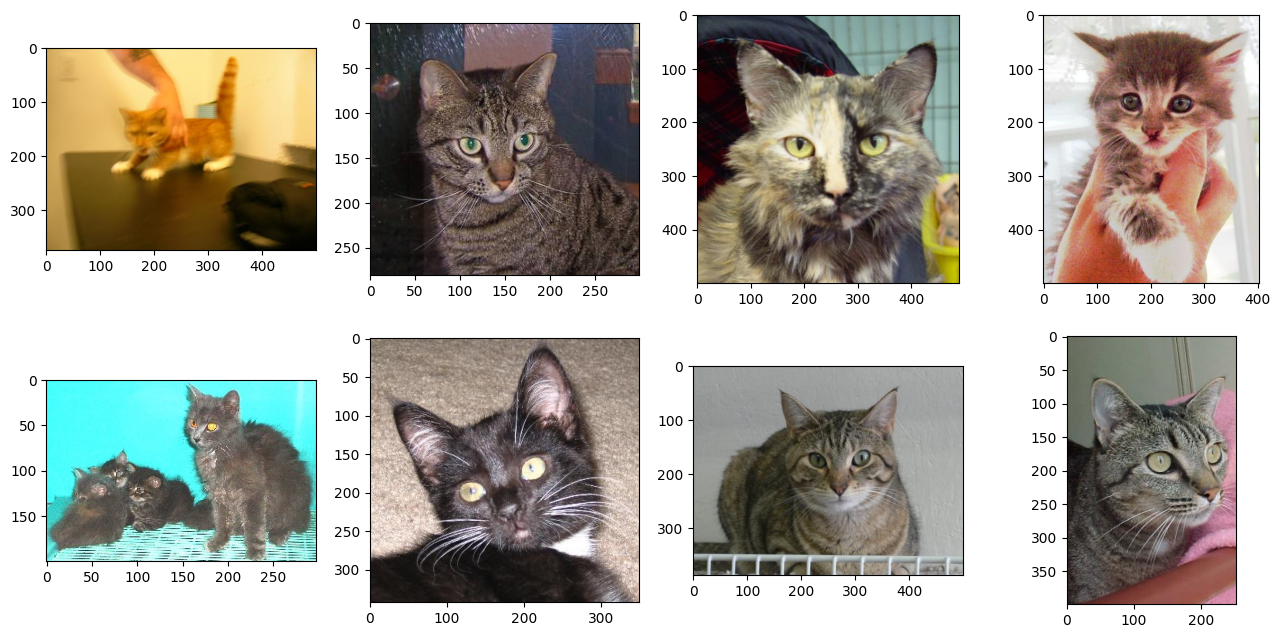

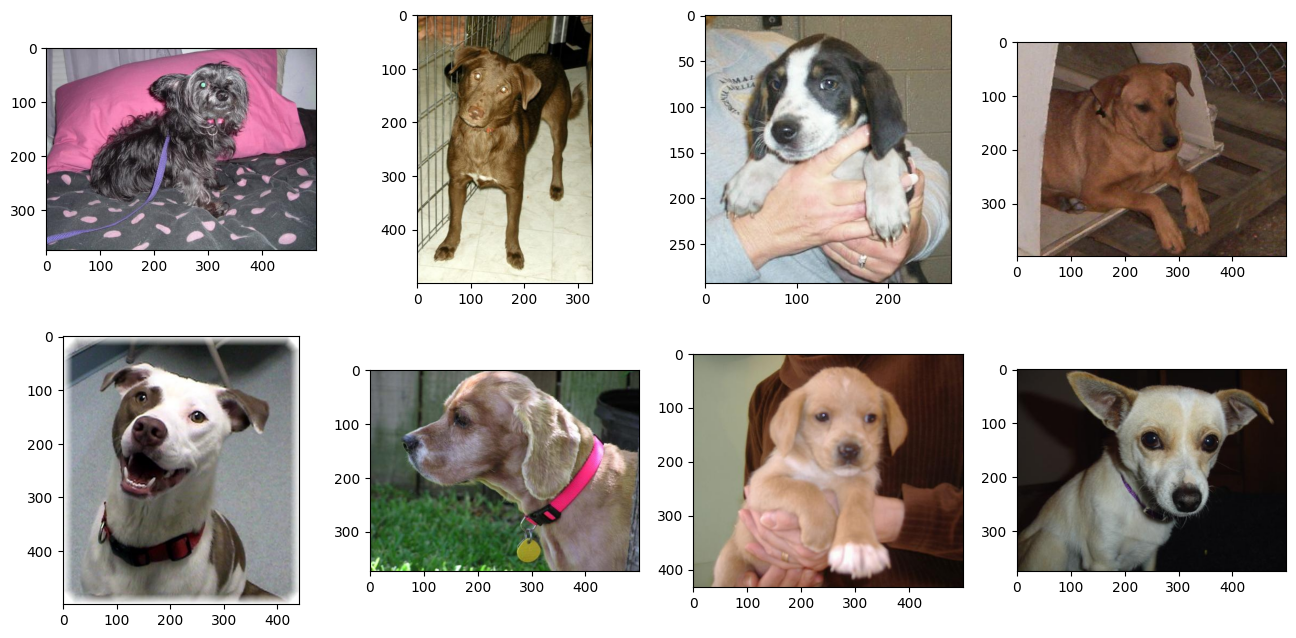

In [4]:
# ver las imagenes del dataset
def print_pictures(dir, fnames):
    nrows = 4
    ncols = 4

    pic_index = 0 # indice para iterar sobre las imagenes

    fig = plt.gcf()
    fig.set_size_inches(ncols*4, nrows*4)

    pic_index += 8

    next_pix = [os.path.join(dir, fname)
                for fname in fnames[pic_index-8:pic_index]
               ]
    for i, img_path in enumerate(next_pix):
        sp = plt.subplot(nrows, ncols, i + 1)
        img = mpimg.imread(img_path)
        plt.imshow(img)
    
    plt.show()


# Obtener archivos de cada categoría
cat_files = os.listdir(os.path.join(DATASET_DIR, "cat"))
dog_files = os.listdir(os.path.join(DATASET_DIR, "dog"))

# Mostrar los gatos y perros
print_pictures(os.path.join(DATASET_DIR, "cat"), cat_files)
print_pictures(os.path.join(DATASET_DIR, "dog"), dog_files)

## Desarrollo de la Práctica

In [5]:
# creamos train (50%), validation (25%) y test(25%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y) # train

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp) # validation y test

# comprobarlo
print("Forma de X_train:", X_train.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (1000, 224, 224, 3)
Forma de y_train: (1000,)
Forma de X_val: (500, 224, 224, 3)
Forma de y_val: (500,)
Forma de X_test: (500, 224, 224, 3)
Forma de y_test: (500,)


In [12]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Ajustar el generador a los datos de entrenamiento
datagen.fit(X_train)

In [8]:
# creacion de nuestra red convolucional de reconocimiento de imagenes
model = Sequential()
model.add(Conv2D(32,(3,3), activation='relu', # utiliza 32 filtros y se usan relus para tener siempre valores positivos
                 input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))) # X * Y * rgb
model.add(MaxPooling2D(2,2)) # reduce el tamaño a la mitad
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten()) # convierte la matriz a una sola dimension
model.add(Dense(512, activation='relu')) # 512 neuronas completamente conectadas
model.add(Dropout(0.5)) # Dropout para evitar overfitting
model.add(Dense(1, activation='sigmoid')) # función sigmoide para decir perro o gato, una sola neurona

model.summary()

/home/mike/python/.venv/lib/python3.13/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
E0000 00:00:1763675315.823541   60947 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1763675315.832127   60947 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     9,437,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,679,041 (36.92 MB)

 Trainable params: 9,679,041 (36.92 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Configuración de los hiperparámetros

# Optimizador
model.compile(optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['acc'])

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Reduce Learning Rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    min_lr=1e-7,
    verbose=1
)

# Guardar mejor modelo
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [17]:
# Entrenar el modelo
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - acc: 0.4738 - loss: 26.4696

2025-11-20 23:00:11.829008: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 301056000 exceeds 10% of free system memory.


31/31 ━━━━━━━━━━━━━━━━━━━━ 30s 921ms/step - acc: 0.4876 - loss: 12.8976 - val_acc: 0.5040 - val_loss: 0.8195 - learning_rate: 1.0000e-04
Epoch 2/50
 1/31 ━━━━━━━━━━━━━━━━━━━━ 25s 854ms/step - acc: 0.5000 - loss: 1.1500

/home/mike/python/.venv/lib/python3.13/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - acc: 0.5000 - loss: 1.1500 - val_acc: 0.5080 - val_loss: 0.9529 - learning_rate: 1.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 914ms/step - acc: 0.5227 - loss: 0.8456 - val_acc: 0.5580 - val_loss: 0.6831 - learning_rate: 1.0000e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - acc: 0.5938 - loss: 0.6607 - val_acc: 0.5600 - val_loss: 0.6834 - learning_rate: 1.0000e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 28s 908ms/step - acc: 0.5475 - loss: 0.7146 - val_acc: 0.5780 - val_loss: 0.6862 - learning_rate: 1.0000e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - acc: 0.6250 - loss: 0.6021 - val_acc: 0.5820 - val_loss: 0.6877 - learning_rate: 1.0000e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 29s 917ms/step - acc: 0.5888 - loss: 0.6750 - val_acc: 0.5880 - val_loss: 0.6724 - learning_rate: 1.0000e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step - acc: 0.6562 - loss: 0.6136 - val_acc: 0.5900 - val_loss: 0.6734 - learning_rate:

/tmp/ipykernel_60947/1851195969.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


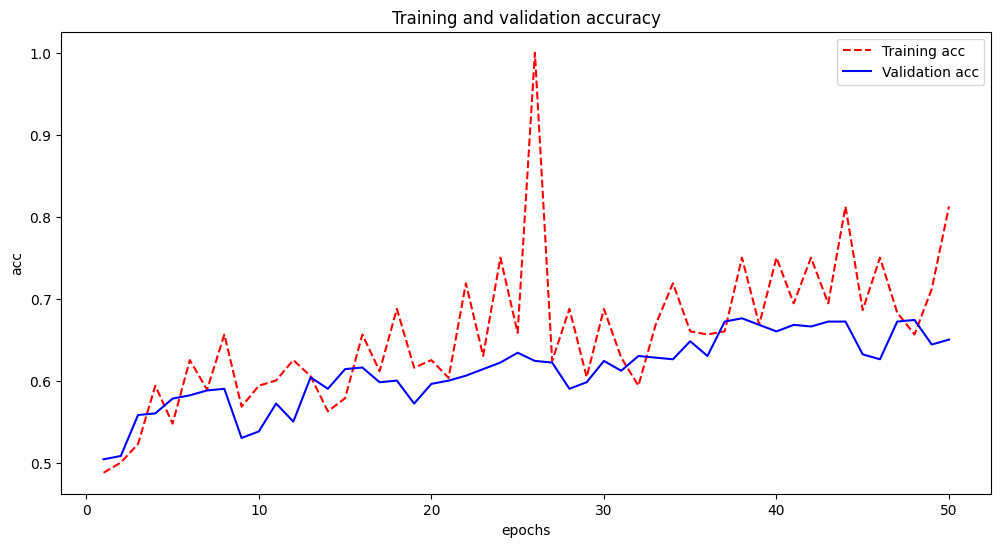

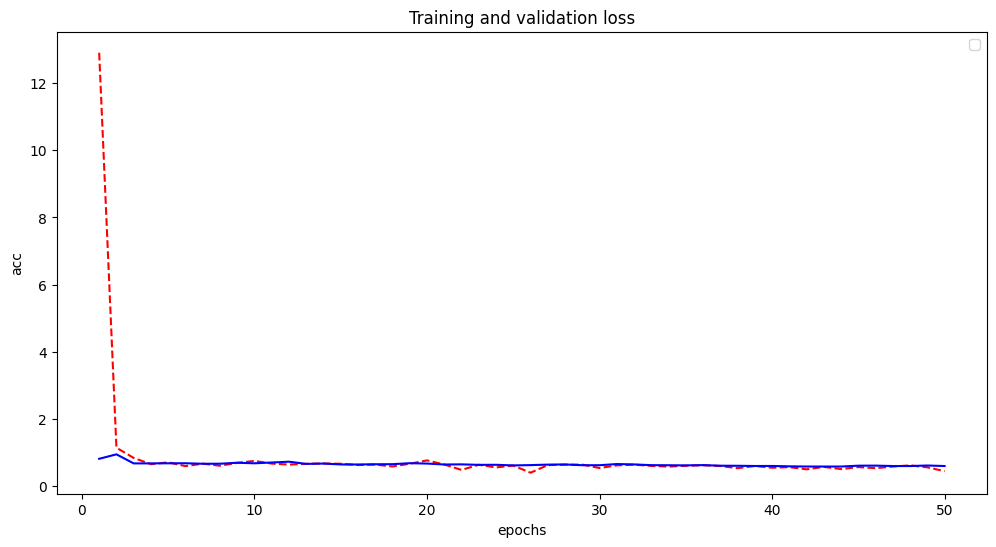

<Figure size 1200x600 with 0 Axes>

In [20]:
# Visualización del comportamiento del entrenamiento
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1, 1)

def showAccuracy():
    plt.plot(epochs, acc, 'r--', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    
    plt.legend()
    plt.figure()


def showLoss():
    plt.plot(epochs, loss, 'r--')
    plt.plot(epochs, val_loss, 'b')
    plt.title('Training and validation loss')
    plt.ylabel('acc')
    plt.xlabel('epochs')
    
    plt.legend()
    plt.figure()

showAccuracy()
showLoss()

In [21]:
# ver resultados con el test
test_lost, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test accuracy: ", test_acc)
print("Test loss: ", test_lost)

2025-11-20 23:25:28.086787: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 301056000 exceeds 10% of free system memory.


Test accuracy:  0.6700000166893005
Test loss:  0.6252498626708984


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicción: [[0.48920053]]


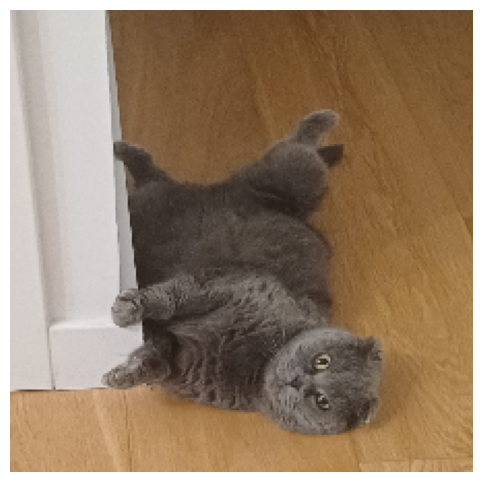

lupe.jpg IS A CAT


In [27]:
# Ahora veamos si mi gato es un gato o un perro
path = 'lupe.jpg'
img = image.load_img(path, target_size=(IMG_SIZE[0], IMG_SIZE[1]))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

classes = model.predict(x)

print("Predicción:", classes)

plt.imshow(img)
plt.axis('off')
plt.show()

# Decidir si es gato o perro
if classes[0][0] > 0.5:
    print(path + " IS A DOG")
else:
    print(path + " IS A CAT")